#**Imports**#

In [1]:
!pip install jsonlines

In [2]:
#test device
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import jsonlines

import pandas as pd
import numpy as np

from typing import Tuple, List, Dict, Optional
from collections import Counter, defaultdict

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
!rm -rf sample_data
!mkdir data

In [6]:
%cd data

/content/data


In [7]:
#directory to save checkpoints and path to it
root_folder = '/content/data/' 
!mkdir output_folder
PATH_OUTPUT_FOLDER = os.path.join(root_folder, 'output_folder/')

In [8]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw1/

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [9]:
#datasets
train_path = 'nlp2021-hw1/data/train.jsonl'
dev_path = 'nlp2021-hw1/data/dev.jsonl'

In [10]:
#borrowed from evaluation.py function to read datasets the same format as during testing
def read_dataset(path: str) -> Tuple[List[Dict], List[str]]:

    sentence_pairs = []
    labels = []

    with jsonlines.open(path) as f:
        for obj in f:
            labels.append(obj.pop('label'))
            sentence_pairs.append(obj)

    assert len(sentence_pairs) == len(labels)

    return sentence_pairs, labels

In [12]:
#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#tried with 100d, 200d, 300d, finally 50d are chosen
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt
!rm glove.6B.zip

--2021-07-18 14:18:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-18 14:18:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-18 14:18:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
#fix chosen dimension
n_embedding = 50

#**Build Viocabulary**#

In [15]:
#dictionary maps words to their embedded representations from Glove
word_vectors = dict()
with open('glove.6B.50d.txt') as f:

    for i, line in tqdm(enumerate(f)):

        word, *vector = line.strip().split(' ')

        vector = torch.tensor([float(c) for c in vector])
        
        word_vectors[word] = vector

In [31]:
#create indexed vocabulary
word_index = dict()
vectors_store = []

#pad token, index = 0
vectors_store.append(torch.rand(n_embedding))

#unk token, index = 1
vectors_store.append(torch.rand(n_embedding))

#sep token, index = 2 
#first idea to manage separation token, then decided to change to the dot token which is already included into GloVe
#vectors_store.append(torch.rand(100))

for word, vector in word_vectors.items():
  word_index[word] = len(vectors_store)
  vectors_store.append(vector)

word_index = defaultdict(lambda: 1, word_index)
vectors_store = torch.stack(vectors_store)

In [32]:
#check sizes
vocabulary_size, n_embedding = vectors_store.shape
print(f"Vocabulary size: {vocabulary_size}")
print(f"Hidden features: {n_embedding}")

Vocabulary size: 400002
Hidden features: 50


In [29]:
sentence = train_samples[10]['sentence2']
target_word = sentence[int(train_samples[10]['start2']): int(train_samples[10]['end2'])]

  #hyphen issue dealing, example of issue: sample 322 in train dataset, sentence 2
cleaned_sentence = re.sub('-', ' ', sentence)

  #slash issue dealing, example of issue: sample 1987 in train dataset, sentence 2
cleaned_sentence = re.sub('/', ' ', cleaned_sentence)

  #dash dealing, example of issue: sample 7026 in train dataset, sentence 2
cleaned_sentence = re.sub('—', ' ', cleaned_sentence)

  #numbers deletion
unnumbered_sentence = re.sub(r'\d+', '', cleaned_sentence)

  #punctuation removal
cleaned_sentence = unnumbered_sentence.translate(str.maketrans('', '', string.punctuation))

  #lowercasing
lowered_sentence = cleaned_sentence.lower()
target_word = target_word.lower()

  #stop words removal except for the cases when stp word = target word or it's lemma
stop_words = set(stopwords.words('english'))
if target_word in stop_words:
  stop_words.remove(target_word)
lemmatizer = WordNetLemmatizer()
target_word = lemmatizer.lemmatize(target_word)
if target_word in stop_words:
  stop_words.remove(target_word)

  #tokenizing and filtering
word_tokens = word_tokenize(lowered_sentence)
filtered_sentence = [word for word in word_tokens if not word in stop_words]
print(sentence)
print(target_word)
print(filtered_sentence)
lemmatized_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]
print(lemmatized_sentence)

It will place as many demands on our material resources as on our intellectual capabilities.
intellectual
['place', 'many', 'demands', 'material', 'resources', 'intellectual', 'capabilities']
['place', 'many', 'demand', 'material', 'resource', 'intellectual', 'capability']


#**Preprocessing**#

In [33]:
def rnn_preprocessing(sentence: str, start_idx: str, end_idx: str) -> torch.Tensor:

  #get target word
  target_word = sentence[int(start_idx): int(end_idx)]

  #hyphen issue dealing, example of issue: sample 322 in train dataset, sentence 2
  cleaned_sentence = re.sub('-', ' ', sentence)

  #slash issue dealing, example of issue: sample 1987 in train dataset, sentence 2
  cleaned_sentence = re.sub('/', ' ', cleaned_sentence)

  #dash dealing, example of issue: sample 7026 in train dataset, sentence 2
  cleaned_sentence = re.sub('—', ' ', cleaned_sentence)

  #numbers deletion
  unnumbered_sentence = re.sub(r'\d+', '', cleaned_sentence)

  #punctuation removal
  cleaned_sentence = unnumbered_sentence.translate(str.maketrans('', '', string.punctuation))

  #lowercasing
  lowered_sentence = cleaned_sentence.lower()
  target_word = target_word.lower()

  #stop words removal except for the cases when stp word = target word or it's lemma
  stop_words = set(stopwords.words('english'))
  if target_word in stop_words:
    stop_words.remove(target_word)
  lemmatizer = WordNetLemmatizer()
  target_word = lemmatizer.lemmatize(target_word)
  if target_word in stop_words:
    stop_words.remove(target_word)

  #tokenizing and filtering
  word_tokens = word_tokenize(lowered_sentence)
  filtered_sentence = [word for word in word_tokens if not word in stop_words]

  #unknown word removal
  #first idea to remove unknown tokens was to collect them into special list
  #unk_words = set(unk_list)
  #filtered_sentence2 = [word for word in filtered_sentence if not word in unk_words]

  #stemming
  #experiments with stemming
  #porter = PorterStemmer()
  #stemmed_sentence = [porter.stem(word) for word in filtered_sentence]

  #lemmatizing
  lemmatized_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]

  #removal unknown tokens if they are not target, removal orginized through using index in vocabulary for unknown tokens
  for word in lemmatized_sentence:
    if word_index[word]==1 and word != target_word:
      lemmatized_sentence.remove(word)
        
  return lemmatized_sentence

In [ ]:
#to check preprocessing
'''dev, _ = read_dataset(dev_path)
for i, d in enumerate(dev):
    print(d['sentence1'])
    print(d['sentence2'])
    sentence1, target1 = rnn_preprocessing(d['sentence1'], d['start1'], d['end1'])
    sentence2, target2 = rnn_preprocessing(d['sentence2'], d['start2'], d['end2'])
    print(rnn_preprocessing(d['sentence1'], d['start1'], d['end1']))
    print(rnn_preprocessing(d['sentence2'], d['start2'], d['end2']))
    print(rnn_sentence2indices(sentence1))
    print(rnn_sentence2indices(sentence2))
    break'''
  

"dev, _ = read_dataset(dev_path)\nfor i, d in enumerate(dev):\n  if i == 8:\n    print(d['sentence1'])\n    print(d['sentence2'])\n    sentence1, target1 = rnn_preprocessing(d['sentence1'], d['start1'], d['end1'])\n    sentence2, target2 = rnn_preprocessing(d['sentence2'], d['start2'], d['end2'])\n    print(rnn_preprocessing(d['sentence1'], d['start1'], d['end1']))\n    print(rnn_preprocessing(d['sentence2'], d['start2'], d['end2']))\n    print(rnn_sentence2indices(sentence1))\n    print(rnn_sentence2indices(sentence2))"

In [34]:
#replace tokenized sentence with the tensor of index corresponding to the tokens
def rnn_sentence2indices(sentence: torch.Tensor) -> torch.Tensor:
    return torch.tensor([word_index[word] for word in sentence], dtype=torch.long)

In [35]:
#merge two lists of tokens with a dot token and replace them by indices
def rnn_sentences2one(sentence1: str, start1: str, end1: str,
                  sentence2: str, start2: str, end2: str) -> torch.Tensor:

  sentence1 = rnn_preprocessing(sentence1, start1, end1)
  sentence1.append('.')
  sentence2 = rnn_preprocessing(sentence2, start2, end2)
  sentence = sentence1 + sentence2

  return rnn_sentence2indices(sentence)

In [ ]:
#check sentence2one
'''train, _ = read_dataset(train_path)
for i, d in enumerate(train):
  print(d['sentence1'])
  print(d['start1'])
  print(d['end1'])
  print(rnn_preprocessing(d['sentence1'], d['start1'], d['end1']))
  print(rnn_sentences2one(d['sentence1'], d['start1'], d['end1'], d['sentence2'], d['start2'], d['end2']))
  break'''

"train, _ = read_dataset(train_path)\nfor i, d in enumerate(train):\n  print(d['sentence1'])\n  print(d['start1'])\n  print(d['end1'])\n  print(rnn_preprocessing(d['sentence1'], d['start1'], d['end1']))\n  print(rnn_sentences2one(d['sentence1'], d['start1'], d['end1'], d['sentence2'], d['start2'], d['end2']))\n  break"

#**Dataset**#

In [50]:
class WiCDatasetRNN(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str):
        self.data_store = []
        self.init_structures(dataset_path)

    def init_structures(self, dataset_path: str) -> None:

        sentence_pairs, labels = read_dataset(dataset_path)

        for i, d in enumerate(sentence_pairs):
          
          # extract relevant fields from the input dictionaries
          sentence1 = d['sentence1']
          start1 = d['start1']
          end1 = d['end1']

          sentence2 = d['sentence2']
          start2 = d['start2']
          end2 = d['end2']
          
          #apply preprocessing
          sentences_vector = rnn_sentences2one(sentence1, start1, end1, sentence2, start2, end2)

          #collect preprocessed inputs in a preprocessed dataset, transform string labels to their numerical equivalents
          self.data_store.append((sentences_vector, np.float32(labels[i]=='True')))

    # basic requirements for a dataset constructor functionality to iterate over it
    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]

In [ ]:
#check dataset
'''dataset = WiCDatasetRNN(train_path)
dataset[0]'''

(tensor([ 4712,  6411,  4986,  6691,   804,   640,   284,   548,  2953,   382,
             4,  2150,   284,  1700,    54,  4426, 12820,    89,   124]), 0.0)

In [52]:
# collate function provides padding of a sequences within a batch to have an equal length
def rnn_collate_fn(
    data_elements: List[Tuple[torch.Tensor, torch.Tensor]] 
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    # list of tensors with indeces
    X = [de[0] for de in data_elements]  

    # to store where is the last word in each sequence
    X_lengths = torch.tensor([x.size(0) for x in X], dtype=torch.long)

    # was used during experiments with padding
    '''target_indices = [de[1] for de in data_elements]
    #print(target_indices)'''

    # zero padding
    X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)  #  shape (batch_size x max_seq_len)

    # was used during experiments with padding
    ''''for i_s, sequence in enumerate(X):
      for i_w, word_idx in enumerate(sequence):
        if i_w > X_lengths[i_s] - 1:
          X[i_s][i_w] = target_indices[i_s]'''

    y = [de[1] for de in data_elements]
    y = torch.tensor(y)

    return X, X_lengths, y

In [ ]:
#check collate fn
'''train_dataloader = DataLoader(dataset, batch_size=6, collate_fn=rnn_collate_fn)
for X, X_length, y in train_dataloader:
  print(X)
  print(X_length)
  print(y)
  break'''

tensor([[  4712,   6411,   4986,   6691,    804,    640,    284,    548,   2953,
            382,      4,   2150,    284,   1700,     54,   4426,  12820,     89,
            124,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0],
        [  4712,   6411,   4986,   6691,    804,    640,    284,    548,   2953,
            382,      4,    166,    432,    913,   1751,    690,  18186,    584,
             81,    422,    808,    284,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0],
        [    56,     54,    119,  11193,  16334,  58214,  25182,   1630,     71,
          14810,   3177,    484,    155,      4,    631, 121268,     18,    106,
            515,    559,    243,  12884,  16334,     71,  21690,      0,      0,
              0,      0,      0,      0,      0],
        [    56,     54,    119,  11193,  16334,  58214,  25182,   1630,     71,
          14810,   3177,    484,    155,

#**Model**#

In [44]:
class WiCClassifierRNN(nn.Module):

    def __init__(self, vectors_store: torch.Tensor, hparams, device): 
        super().__init__()

        self.device = device

        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)

        # recurrent layer
        self.rnn = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=hparams.n_hidden,
                                 bidirectional=hparams.bidirectional,
                                 num_layers=hparams.num_layers, 
                                 dropout=hparams.dropout, #applied only when num_layers > 1
                                 batch_first=True)
        
        # for experiments with bidirectional architecture
        n_hidden = hparams.n_hidden if hparams.bidirectional is False else hparams.n_hidden * 2

        # dropout layer
        self.dropout = torch.nn.Dropout(hparams.dropout)

        #normalization layer, was used for experiments (but there was also separate method in the class to adapt it working properly)
        #self.BatchNorm = nn.BatchNorm1d(n_hidden)

        # classification layers
        self.lin1 = torch.nn.Linear(n_hidden, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        
        # Binary Cross-Entropy
        self.loss_fn = torch.nn.BCELoss()
        
        # initialize epoch counter
        self.global_epoch = 0


    def forward(self, X: torch.Tensor,
                X_length: torch.Tensor,
                y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        

        # embedding layer
        embedding_out = self.embedding(X)

        # dropout layer
        dropout_out = self.dropout(embedding_out)

        # recurrent layer
        recurrent_out, (h, c) = self.rnn(dropout_out)

        batch_size, seq_len, hidden_size = recurrent_out.shape

        # dropout layer again
        dropout_out = self.dropout(recurrent_out)

        # long vector in which we want to locate recurrent outputs corresponding to last tokens in the sentences
        flattened_out = dropout_out.reshape(-1, hidden_size)

        # relacements from the beginning of each sentence
        last_word_relative_indices = X_length - 1
        # beginnings of each sentence
        sequences_offsets = torch.arange(batch_size, device=self.device) * seq_len
        # locations of outputs of a recurrent (and dropouted) layer corresponding to the ends of sentences
        summary_vectors_indices = sequences_offsets + last_word_relative_indices

        # outputs of a recurrent layer corresponding to each found location
        summary_vectors = flattened_out[summary_vectors_indices]

        # classification layers
        out = self.lin1(summary_vectors)
        #out = self.BatchNorm(out)
        #out = torch.relu(out)
        #out = nn.LeakyReLU(0.2)(out)
        out = torch.relu(out)
        #out = torch.tanh(out)
        #out = self.dropout(out)
        out = self.lin2(out).squeeze(1)

        # compute predictions in [0, 1] interval
        pred = torch.sigmoid(out)

        result = {'logits': out, 'pred': pred}

        # compute loss
        if y is not None:
            loss = self.loss(pred, y)
            result['loss'] = loss

        return result

    # initialize loss function
    def loss(self, pred, y):
        return self.loss_fn(pred, y)


#**Training and Evaluation**#

In [46]:
class TrainerRNN():

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer):

        self.model = model
        self.optimizer = optimizer
        self.device = self.model.device

        self.model.to(self.device)

    def train_and_evaluate(self, 
        output_folder, # to save checkpoints
        train_dataloader: DataLoader, # datasets
        dev_dataloader: DataLoader = None,
        dev_fn = None, # to compute accuracy
        epochs: int = 5, # to manage training
        early_stopping: bool = False,
        early_stopping_mode: str = 'accuracy',
        early_stopping_patience: int = 0,
        verbose: bool = True,
        eps: float = 0.009,
        save_interval: int = 10
    ):

        # will store training and evaluation history (both loss and accuracy)
        train_loss = []
        train_accuracy = []
        dev_loss = []
        dev_accuracy = []
        patience_counter = 0

        for epoch in range(epochs):
            losses = []
            dev_losses = []

            # training mode
            self.model.train()

            # iterate over train dataloader
            for x, x_length, y in train_dataloader:

                # use GPU
                x = x.to(self.device)
                x_length = x_length.to(self.device)
                y = y.to(self.device)

                # retrieve loss, compute the gradient and make an optimization step
                self.optimizer.zero_grad()
                batch_out = self.model(x, x_length, y)
                loss = batch_out['loss']
                losses.append(loss)
                loss.backward()
                self.optimizer.step()

            self.model.global_epoch += 1

            # collect loss for printing
            mean_loss = sum(losses) / len(losses)
            train_loss.append(mean_loss.item())

            # compute accuracy
            train_output = dev_fn(self.model, train_dataloader, self.device)
            train_name = train_output['name']
            train_value = train_output['value']
            train_accuracy.append(train_value.item())

            if verbose or epoch == epochs - 1:
                print(f'  Epoch {self.model.global_epoch:3d} => Loss: {mean_loss:0.6f}')
                print(f'    Train => {train_name}: {train_value:0.6f}')

            # if dev dataset is given, perform evaluation
            if verbose and dev_dataloader:
                # evaluation mode
                self.model.eval()

                for x, x_lengths, y in dev_dataloader:
                  x = x.to(self.device)
                  x_lengths = x_lengths.to(self.device)
                  y = y.to(self.device)
                  batch_out = self.model(x, x_lengths, y)
                  loss = batch_out['loss']
                  dev_losses.append(loss)

                # collect dev loss
                mean_dev_loss = sum(dev_losses) / len(dev_losses)
                dev_loss.append(mean_dev_loss.item())

                # compute dev accuracy
                assert dev_fn is not None
                dev_output = dev_fn(self.model, dev_dataloader, self.device)
                dev_name = dev_output['name']
                dev_value = dev_output['value']
                dev_accuracy.append(dev_value.item())

                print(f'    Validation => {dev_name}: {dev_value:0.6f}')
                print()

                # to stop training before overfitting
                if early_stopping:
                    # chosen metric to monitor
                    stop = early_stopping_mode == 'loss' and epoch > 0 and dev_loss[-1] > dev_loss[-2]
                    # soft stopping condition (restriction within a certain threshold instead of a priory)
                    stop = stop or early_stopping_mode == 'accuracy' and epoch > 0 and (dev_accuracy[-1] + eps) < dev_accuracy[-2]
                    # set patience and use patience counter to stop
                    if stop:
                        if patience_counter >= early_stopping_patience:
                            print('Early stop.')
                            break
                        else:
                            patience_counter += 1
                            print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')

            # to save checkpoint only for a chosen epochs
            if epoch % save_interval == 0:
              torch.save(self.model.state_dict(), os.path.join(output_folder, 'state_{}.pt'.format(epoch)))
            
        
        # final output history
        return {
            'train_loss': train_loss,
            'dev_loss': dev_loss,
            'train_accuracy': train_accuracy,
            'dev_accuracy': dev_accuracy
        }

In [47]:
# function that uses sklearn accuracy score method to compute accuracy
@torch.no_grad() # to freeze everything that should be freezed during evaluation
def rnn_evaluate_accuracy(model: nn.Module, dataloader: DataLoader, device):
    acc = []
    for x, x_length, y in dataloader:
      x = x.to(device)
      x_length = x_length.to(device)
      

      batch_out = model(x, x_length)
      pred = batch_out['pred']

      pred = torch.round(pred)
      
      pred1 = pred.cpu()
      pred1 = pred1.detach().numpy()
      
      acc.append(accuracy_score(y, pred1))

    accuracy = np.mean(acc)
    return {
        'name': 'Accuracy',
        'value': accuracy
    }

#**Hyperparameters setting and Experiments**#

In [48]:
def optimizers(optimizer_name: str, model: nn.Module, lr: float, 
               weight_decay: float, momentum: float, alpha: float, epsilon: float) -> torch.optim.Optimizer:
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay = weight_decay
            )
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum
            )
    else:
        optimizer = torch.optim.RMSprop(
            model.parameters(),
            lr=lr,
            alpha=alpha,
            eps=epsilon
            )
    return optimizer

In [53]:
#@title Hyperparameters settings

class HParams():
  dropout = 0.0 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 1 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

batch_size = 256 #@param {type:"slider", min:8, max:512, step:8}
patience = 7 #@param {type:"slider", min:1, max:10, step:1}
early_stopping_mode = "accuracy" #@param ["accuracy", "loss"]
eps = 0.01 #@param {type:"slider", min:0.001, max:0.2, step: 0.001}
epochs = 70 #@param {type:"slider", min:50, max:30000, step:50}
save_interval = 10
optimizer_name = "Adam" #@param ["Adam", "SGD", "RMSprop"]
learning_rate = 0.0001 #@param {type:"slider", min:0.00001, max:0.1, step: 0.0001}
momentum = 0.9 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
weight_decay = 1e-6
alpha = 1.0
epsilon = 1e-8

# training procedure
# 1. create dataset
train_dataset2 = WiCDatasetRNN(train_path)
dev_dataset2 = WiCDatasetRNN(dev_path)

# 2. divide into batches
train_dataloader2 = DataLoader(train_dataset2, 
  batch_size=batch_size, 
  collate_fn=rnn_collate_fn, shuffle=True)
dev_dataloader2 = DataLoader(dev_dataset2, 
  batch_size=batch_size, 
  collate_fn=rnn_collate_fn)

# manage memory
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# 3. initialize model
recurrent_model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

# set optimizer
optimizer = optimizers("Adam", recurrent_model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)

# 4. initialize trainer
trainer = TrainerRNN(recurrent_model, 
                          optimizer)

# 5. run training
'''logs = trainer.train_and_evaluate(
    PATH_OUTPUT_FOLDER,
    train_dataloader=train_dataloader2,
    dev_dataloader=dev_dataloader2,
    dev_fn=rnn_evaluate_accuracy,
    early_stopping=False,
    early_stopping_mode=early_stopping_mode,
    early_stopping_patience=patience,
    eps=eps,
    epochs=epochs,
    save_interval=save_interval
    )'''

cuda


'logs = trainer.train_and_evaluate(\n    PATH_OUTPUT_FOLDER,\n    train_dataloader=train_dataloader2,\n    dev_dataloader=dev_dataloader2,\n    dev_fn=rnn_evaluate_accuracy,\n    early_stopping=False,\n    early_stopping_mode=early_stopping_mode,\n    early_stopping_patience=patience,\n    eps=eps,\n    epochs=epochs,\n    save_interval=save_interval\n    )'

#**Save and Load**#

In [ ]:
#load best weights model to check
'''model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )
model.load_state_dict(torch.load(os.path.join(PATH_OUTPUT_FOLDER, 'state_{}.pt'.format(63)), 
                                     map_location=torch.device(device)))'''

"model = WiCClassifierRNN(\n    vectors_store=vectors_store,\n    hparams=hparams,\n    device=device\n    )\nmodel.load_state_dict(torch.load(os.path.join(PATH_OUTPUT_FOLDER, 'state_{}.pt'.format(63)), \n                                     map_location=torch.device(device)))"

In [ ]:
#check accuracy of a best model: 0.6681
'''acc = rnn_evaluate_accuracy(model, dev_dataloader2, device=device)
acc['value']'''

"acc = rnn_evaluate_accuracy(model, dev_dataloader2, device=device)\nacc['value']"

In [ ]:
#to save with custom name
#torch.save(model.state_dict(), os.path.join(PATH_OUTPUT_FOLDER, 'rnn_best_weights.pt'))

#**Collect and Draw history over set of trials**#

In [ ]:
#drawing function
def plot_logs(train_logs: list, dev_logs: list, title: str, mode: str):

    fig = plt.figure(figsize=(8,6))

    num_trials = len(train_logs)
    last_idx = num_trials - 1

    for i in range(last_idx):
      plt.plot(list(range(len(train_logs[i]))), train_logs[i], color = 'green')
      plt.plot(list(range(len(dev_logs[i]))), dev_logs[i], color = 'red')
    

    plt.plot(list(range(len(train_logs[last_idx]))), train_logs[last_idx], color = 'green', label = 'Train')
    plt.plot(list(range(len(dev_logs[last_idx]))), dev_logs[last_idx], color = 'red', label = 'Dev')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(mode)
    plt.legend(loc="upper left")

    plt.show()
    fig.savefig('{}.png'.format(title),  dpi=fig.dpi)


#Baseline 2#

In [ ]:

class HParams():
  dropout = 0.0 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 1 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

train_accuracy_history = []
dev_accuracy_history = []
train_loss_history = []
dev_loss_history = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

  optimizer = optimizers("Adam", model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)


  trainer = TrainerRNN(model, 
                            optimizer)

  logs = trainer.train_and_evaluate(
      PATH_OUTPUT_FOLDER,
      train_dataloader=train_dataloader2,
      dev_dataloader=dev_dataloader2,
      dev_fn=rnn_evaluate_accuracy,
      early_stopping=False,
      early_stopping_mode=early_stopping_mode,
      early_stopping_patience=patience,
      eps=eps,
      epochs=epochs,
      save_interval=save_interval
      )
  train_accuracy_history.append(logs['train_accuracy'])
  dev_accuracy_history.append(logs['dev_accuracy'])
  train_loss_history.append(logs['train_loss'])
  dev_loss_history.append(logs['dev_loss'])


EVALUATION 1
  Epoch   1 => Loss: 0.694385
    Train => Accuracy: 0.500732
    Validation => Accuracy: 0.501313

  Epoch   2 => Loss: 0.693161
    Train => Accuracy: 0.516724
    Validation => Accuracy: 0.521451

  Epoch   3 => Loss: 0.692646
    Train => Accuracy: 0.524902
    Validation => Accuracy: 0.534483

  Epoch   4 => Loss: 0.692323
    Train => Accuracy: 0.527832
    Validation => Accuracy: 0.539366

  Epoch   5 => Loss: 0.691927
    Train => Accuracy: 0.533691
    Validation => Accuracy: 0.536133

  Epoch   6 => Loss: 0.691623
    Train => Accuracy: 0.538330
    Validation => Accuracy: 0.545999

  Epoch   7 => Loss: 0.691029
    Train => Accuracy: 0.539307
    Validation => Accuracy: 0.545696

  Epoch   8 => Loss: 0.690634
    Train => Accuracy: 0.539185
    Validation => Accuracy: 0.548929

  Epoch   9 => Loss: 0.690134
    Train => Accuracy: 0.539551
    Validation => Accuracy: 0.559469

  Epoch  10 => Loss: 0.690008
    Train => Accuracy: 0.541748
    Validation => Accurac

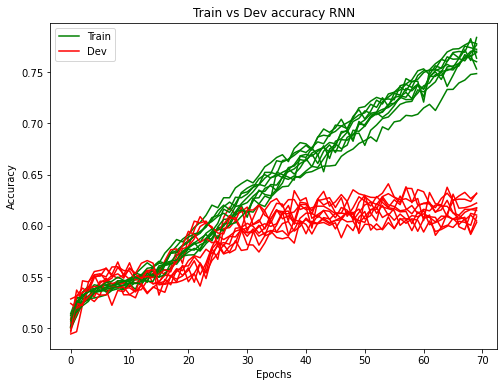

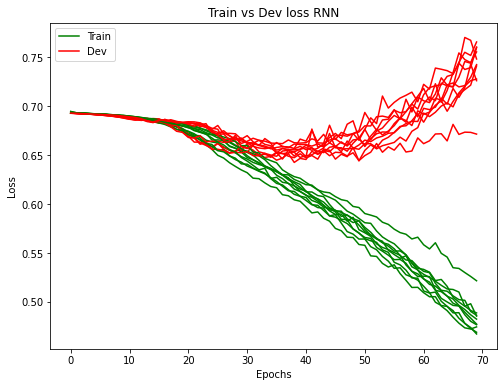

In [ ]:
plot_logs(train_accuracy_history, dev_accuracy_history, 'Train vs Dev accuracy RNN', 'Accuracy')
plot_logs(train_loss_history, dev_loss_history, 'Train vs Dev loss RNN', 'Loss')

In [ ]:
#averaged history
mean_train_accuracy = torch.mean(torch.tensor(train_accuracy_history), axis = 0)
mean_dev_accuracy = torch.mean(torch.tensor(dev_accuracy_history), axis = 0)
mean_train_loss = torch.mean(torch.tensor(train_loss_history), axis = 0)
mean_dev_loss = torch.mean(torch.tensor(dev_loss_history), axis = 0)

In [ ]:
#function to draw averaged history
def plot_mean_logs(train_logs: list, dev_logs: list, title: str, mode: str):

    fig = plt.figure(figsize=(8,6))
    
    plt.plot(list(range(len(train_logs))), train_logs, color = 'green', label = 'Train')
    plt.plot(list(range(len(dev_logs))), dev_logs, color = 'red', label = 'Dev')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(mode)
    plt.legend(loc="upper left")

    plt.show()
    fig.savefig('{}.png'.format(title),  dpi=fig.dpi)

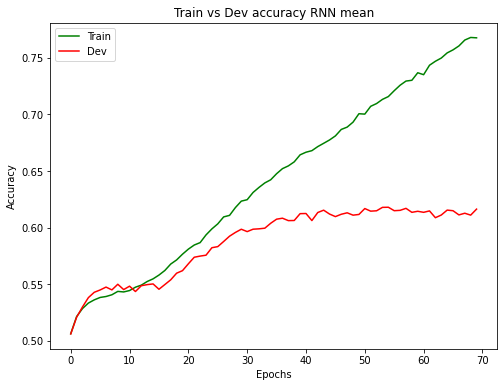

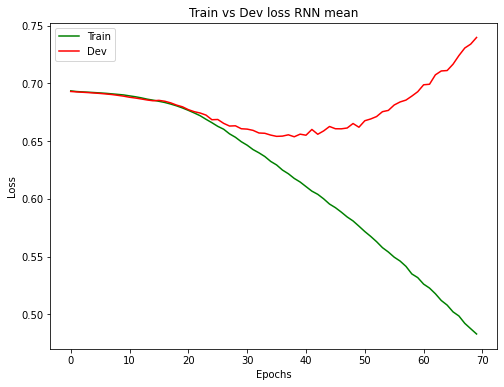

In [ ]:
plot_mean_logs(mean_train_accuracy, mean_dev_accuracy, 'Train vs Dev accuracy RNN mean', 'Accuracy')
plot_mean_logs(mean_train_loss, mean_dev_loss, 'Train vs Dev loss RNN mean', 'Loss')

#Baseline 2, dropout 0.2#

In [ ]:
class HParams():
  dropout = 0.2 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 2 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

train_accuracy_history_dropout = []
dev_accuracy_history_dropout = []
train_loss_history_dropout = []
dev_loss_history_dropout = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

  optimizer = optimizers("Adam", model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)


  trainer = TrainerRNN(model, 
                            optimizer)

  logs = trainer.train_and_evaluate(
      PATH_OUTPUT_FOLDER,
      train_dataloader=train_dataloader2,
      dev_dataloader=dev_dataloader2,
      dev_fn=rnn_evaluate_accuracy,
      early_stopping=False,
      early_stopping_mode=early_stopping_mode,
      early_stopping_patience=patience,
      eps=eps,
      epochs=epochs,
      save_interval=save_interval
      )
  train_accuracy_history_dropout.append(logs['train_accuracy'])
  dev_accuracy_history_dropout.append(logs['dev_accuracy'])
  train_loss_history_dropout.append(logs['train_loss'])
  dev_loss_history_dropout.append(logs['dev_loss'])


EVALUATION 1
  Epoch   1 => Loss: 0.693303
    Train => Accuracy: 0.503784
    Validation => Accuracy: 0.498687

  Epoch   2 => Loss: 0.693056
    Train => Accuracy: 0.505127
    Validation => Accuracy: 0.508654

  Epoch   3 => Loss: 0.692899
    Train => Accuracy: 0.522095
    Validation => Accuracy: 0.542228

  Epoch   4 => Loss: 0.692814
    Train => Accuracy: 0.517578
    Validation => Accuracy: 0.541251

  Epoch   5 => Loss: 0.692642
    Train => Accuracy: 0.515381
    Validation => Accuracy: 0.551253

  Epoch   6 => Loss: 0.692505
    Train => Accuracy: 0.518921
    Validation => Accuracy: 0.549906

  Epoch   7 => Loss: 0.692061
    Train => Accuracy: 0.535645
    Validation => Accuracy: 0.538827

  Epoch   8 => Loss: 0.691666
    Train => Accuracy: 0.530151
    Validation => Accuracy: 0.537850

  Epoch   9 => Loss: 0.691047
    Train => Accuracy: 0.530029
    Validation => Accuracy: 0.554485

  Epoch  10 => Loss: 0.690108
    Train => Accuracy: 0.539795
    Validation => Accurac

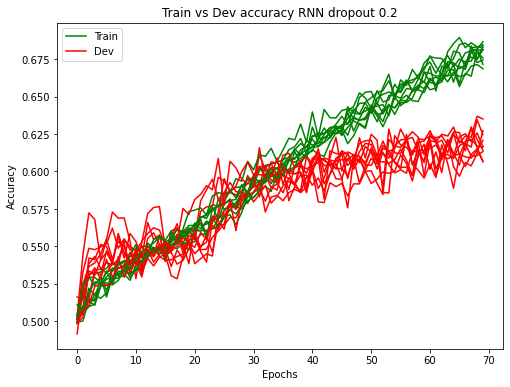

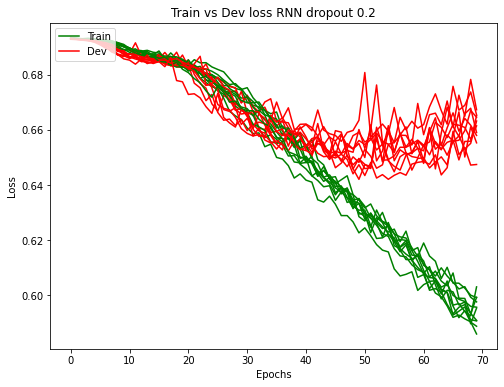

In [ ]:
plot_logs(train_accuracy_history_dropout, dev_accuracy_history_dropout, 'Train vs Dev accuracy RNN dropout 0.2', 'Accuracy')
plot_logs(train_loss_history_dropout, dev_loss_history_dropout, 'Train vs Dev loss RNN dropout 0.2', 'Loss')

In [ ]:
mean_train_accuracy_dropout = torch.mean(torch.tensor(train_accuracy_history_dropout), axis = 0)
mean_dev_accuracy_dropout = torch.mean(torch.tensor(dev_accuracy_history_dropout), axis = 0)
mean_train_loss_dropout = torch.mean(torch.tensor(train_loss_history_dropout), axis = 0)
mean_dev_loss_dropout = torch.mean(torch.tensor(dev_loss_history_dropout), axis = 0)

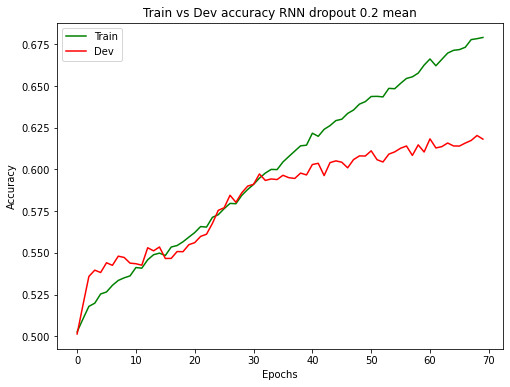

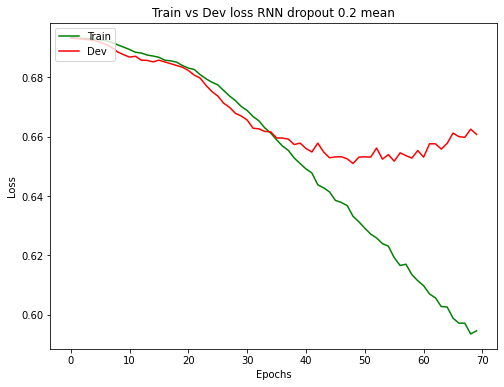

In [ ]:
plot_mean_logs(mean_train_accuracy_dropout, mean_dev_accuracy_dropout, 'Train vs Dev accuracy RNN dropout 0.2 mean', 'Accuracy')
plot_mean_logs(mean_train_loss_dropout, mean_dev_loss_dropout, 'Train vs Dev loss RNN dropout 0.2 mean', 'Loss')

#Baseline 2, dropout 0.5#

In [ ]:
class HParams():
  dropout = 0.5 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 2 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

train_accuracy_history_dropout_05 = []
dev_accuracy_history_dropout_05 = []
train_loss_history_dropout_05 = []
dev_loss_history_dropout_05 = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

  optimizer = optimizers("Adam", model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)


  trainer = TrainerRNN(model, 
                            optimizer)

  logs = trainer.train_and_evaluate(
      PATH_OUTPUT_FOLDER,
      train_dataloader=train_dataloader2,
      dev_dataloader=dev_dataloader2,
      dev_fn=rnn_evaluate_accuracy,
      early_stopping=False,
      early_stopping_mode=early_stopping_mode,
      early_stopping_patience=patience,
      eps=eps,
      epochs=epochs,
      save_interval=save_interval
      )
  train_accuracy_history_dropout_05.append(logs['train_accuracy'])
  dev_accuracy_history_dropout_05.append(logs['dev_accuracy'])
  train_loss_history_dropout_05.append(logs['train_loss'])
  dev_loss_history_dropout_05.append(logs['dev_loss'])

EVALUATION 1
  Epoch   1 => Loss: 0.693668
    Train => Accuracy: 0.501831
    Validation => Accuracy: 0.501313

  Epoch   2 => Loss: 0.693231
    Train => Accuracy: 0.499146
    Validation => Accuracy: 0.501414

  Epoch   3 => Loss: 0.693061
    Train => Accuracy: 0.503662
    Validation => Accuracy: 0.527647

  Epoch   4 => Loss: 0.692909
    Train => Accuracy: 0.504639
    Validation => Accuracy: 0.520979

  Epoch   5 => Loss: 0.692860
    Train => Accuracy: 0.512939
    Validation => Accuracy: 0.520777

  Epoch   6 => Loss: 0.692738
    Train => Accuracy: 0.508667
    Validation => Accuracy: 0.539837

  Epoch   7 => Loss: 0.692717
    Train => Accuracy: 0.507446
    Validation => Accuracy: 0.531923

  Epoch   8 => Loss: 0.692541
    Train => Accuracy: 0.516479
    Validation => Accuracy: 0.526266

  Epoch   9 => Loss: 0.692499
    Train => Accuracy: 0.513428
    Validation => Accuracy: 0.527142

  Epoch  10 => Loss: 0.692065
    Train => Accuracy: 0.516724
    Validation => Accurac

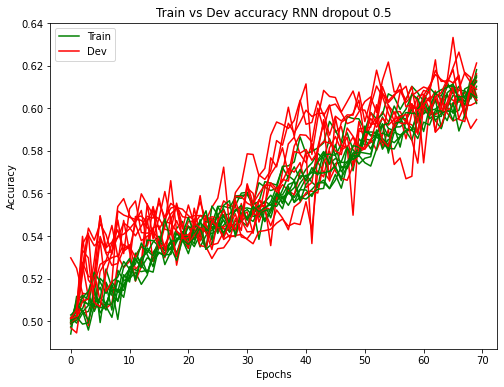

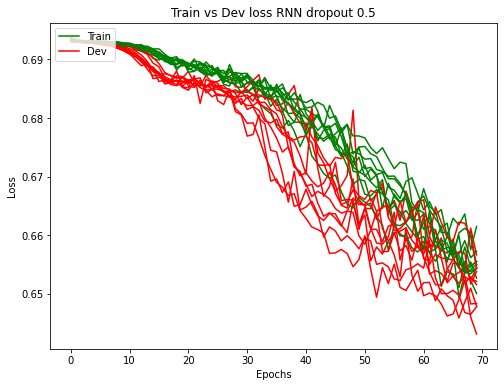

In [ ]:
plot_logs(train_accuracy_history_dropout_05, dev_accuracy_history_dropout_05,
          'Train vs Dev accuracy RNN dropout 0.5', 'Accuracy')
plot_logs(train_loss_history_dropout_05, dev_loss_history_dropout_05, 
          'Train vs Dev loss RNN dropout 0.5', 'Loss')

In [ ]:
mean_train_accuracy_dropout_05 = torch.mean(torch.tensor(train_accuracy_history_dropout_05), axis = 0)
mean_dev_accuracy_dropout_05 = torch.mean(torch.tensor(dev_accuracy_history_dropout_05), axis = 0)
mean_train_loss_dropout_05 = torch.mean(torch.tensor(train_loss_history_dropout_05), axis = 0)
mean_dev_loss_dropout_05 = torch.mean(torch.tensor(dev_loss_history_dropout_05), axis = 0)

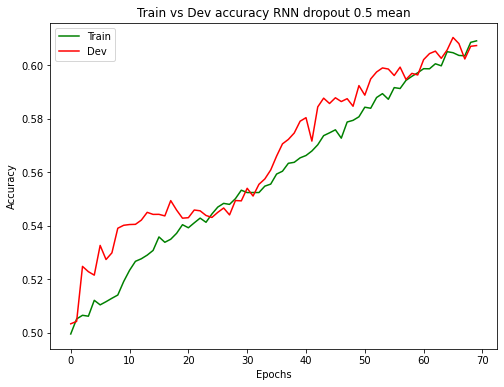

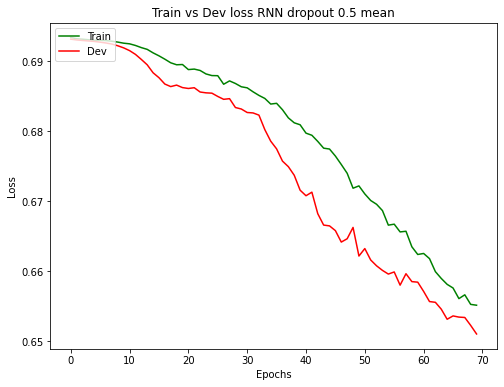

In [ ]:
plot_mean_logs(mean_train_accuracy_dropout_05, mean_dev_accuracy_dropout_05, 
               'Train vs Dev accuracy RNN dropout 0.5 mean', 'Accuracy')
plot_mean_logs(mean_train_loss_dropout_05, mean_dev_loss_dropout_05,
               'Train vs Dev loss RNN dropout 0.5 mean', 'Loss')

#Baseline 2, dropout 0.8#

In [ ]:
class HParams():
  dropout = 0.8 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 2 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

train_accuracy_history_dropout_08 = []
dev_accuracy_history_dropout_08 = []
train_loss_history_dropout_08 = []
dev_loss_history_dropout_08 = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifierRNN(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

  optimizer = optimizers("Adam", model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)


  trainer = TrainerRNN(model, 
                            optimizer)

  logs = trainer.train_and_evaluate(
      PATH_OUTPUT_FOLDER,
      train_dataloader=train_dataloader2,
      dev_dataloader=dev_dataloader2,
      dev_fn=rnn_evaluate_accuracy,
      early_stopping=False,
      early_stopping_mode=early_stopping_mode,
      early_stopping_patience=patience,
      eps=eps,
      epochs=epochs,
      save_interval=save_interval
      )
  train_accuracy_history_dropout_08.append(logs['train_accuracy'])
  dev_accuracy_history_dropout_08.append(logs['dev_accuracy'])
  train_loss_history_dropout_08.append(logs['train_loss'])
  dev_loss_history_dropout_08.append(logs['dev_loss'])

EVALUATION 1
  Epoch   1 => Loss: 0.693637
    Train => Accuracy: 0.498901
    Validation => Accuracy: 0.498687

  Epoch   2 => Loss: 0.693496
    Train => Accuracy: 0.500977
    Validation => Accuracy: 0.498687

  Epoch   3 => Loss: 0.693454
    Train => Accuracy: 0.503906
    Validation => Accuracy: 0.498687

  Epoch   4 => Loss: 0.693215
    Train => Accuracy: 0.499390
    Validation => Accuracy: 0.498687

  Epoch   5 => Loss: 0.693254
    Train => Accuracy: 0.493286
    Validation => Accuracy: 0.499663

  Epoch   6 => Loss: 0.693018
    Train => Accuracy: 0.499023
    Validation => Accuracy: 0.498586

  Epoch   7 => Loss: 0.693384
    Train => Accuracy: 0.500977
    Validation => Accuracy: 0.497508

  Epoch   8 => Loss: 0.693427
    Train => Accuracy: 0.496338
    Validation => Accuracy: 0.497508

  Epoch   9 => Loss: 0.693137
    Train => Accuracy: 0.504639
    Validation => Accuracy: 0.505051

  Epoch  10 => Loss: 0.693191
    Train => Accuracy: 0.501343
    Validation => Accurac

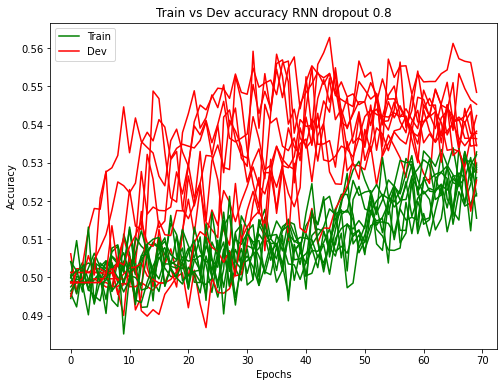

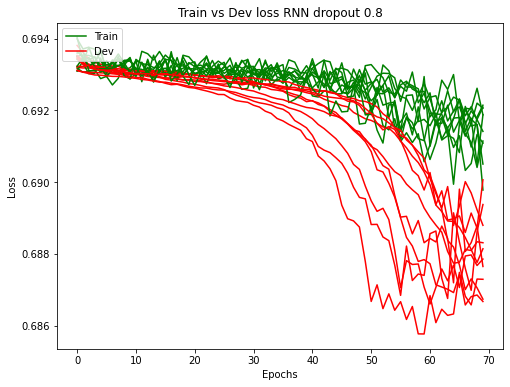

In [ ]:
plot_logs(train_accuracy_history_dropout_08, dev_accuracy_history_dropout_08,
          'Train vs Dev accuracy RNN dropout 0.8', 'Accuracy')
plot_logs(train_loss_history_dropout_08, dev_loss_history_dropout_08, 
          'Train vs Dev loss RNN dropout 0.8', 'Loss')

In [ ]:
mean_train_accuracy_dropout_08 = torch.mean(torch.tensor(train_accuracy_history_dropout_08), axis = 0)
mean_dev_accuracy_dropout_08 = torch.mean(torch.tensor(dev_accuracy_history_dropout_08), axis = 0)
mean_train_loss_dropout_08 = torch.mean(torch.tensor(train_loss_history_dropout_08), axis = 0)
mean_dev_loss_dropout_08 = torch.mean(torch.tensor(dev_loss_history_dropout_08), axis = 0)

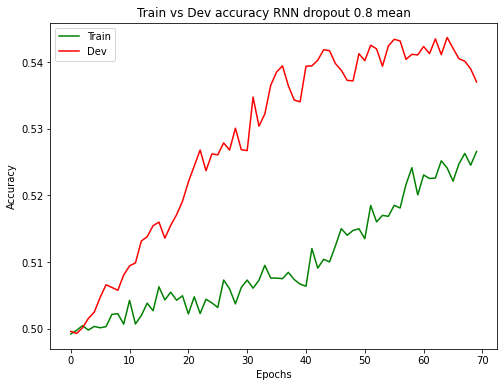

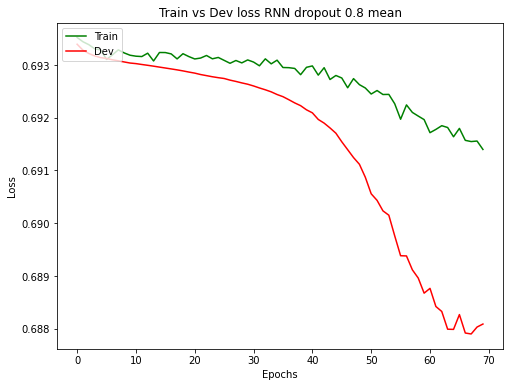

In [ ]:
plot_mean_logs(mean_train_accuracy_dropout_08, mean_dev_accuracy_dropout_08, 
               'Train vs Dev accuracy RNN dropout 0.8 mean', 'Accuracy')
plot_mean_logs(mean_train_loss_dropout_08, mean_dev_loss_dropout_08,
               'Train vs Dev loss RNN dropout 0.8 mean', 'Loss')

#Baseline 2, comparative analysis of different dropout rates#

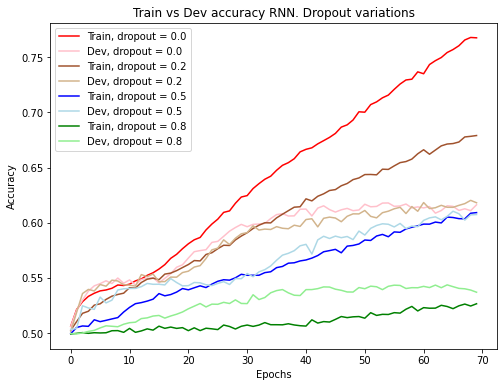

In [ ]:
fig = plt.figure(figsize=(8,6))
    
plt.plot(list(range(len(mean_train_accuracy))), mean_train_accuracy, color = 'red', label = 'Train, dropout = 0.0')
plt.plot(list(range(len(mean_dev_accuracy))), mean_dev_accuracy, color = 'pink', label = 'Dev, dropout = 0.0')
plt.plot(list(range(len(mean_train_accuracy))), mean_train_accuracy_dropout, color = 'sienna', label = 'Train, dropout = 0.2')
plt.plot(list(range(len(mean_dev_accuracy))), mean_dev_accuracy_dropout, color = 'tan', label = 'Dev, dropout = 0.2')
plt.plot(list(range(len(mean_train_accuracy))), mean_train_accuracy_dropout_05, color = 'blue', label = 'Train, dropout = 0.5')
plt.plot(list(range(len(mean_dev_accuracy))), mean_dev_accuracy_dropout_05, color = 'lightblue', label = 'Dev, dropout = 0.5')
plt.plot(list(range(len(mean_train_accuracy))), mean_train_accuracy_dropout_08, color = 'green', label = 'Train, dropout = 0.8')
plt.plot(list(range(len(mean_dev_accuracy))), mean_dev_accuracy_dropout_08, color = 'lightgreen', label = 'Dev, dropout = 0.8')

plt.title('Train vs Dev accuracy RNN. Dropout variations')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

plt.show()
fig.savefig('Train vs Dev accuracy RNN. Dropout variations.png',  dpi=fig.dpi)